In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import json
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


warnings.filterwarnings('ignore')

# Konfiguracja wykresów
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

print("=== PROJEKT LSTM: Prognozowanie kursu CDR.WA ===")

=== PROJEKT LSTM: Prognozowanie kursu CDR.WA ===


In [62]:
def load_cdr_data():
    """Wczytuje dane CDR.WA z lokalnego pliku CSV w Twoim formacie"""
    
    # Sprawdzenie dostępnych plików (ścieżki z perspektywy notebooks/)
    possible_files = [
        '../data/cdr_raw_data.csv',      # główna lokalizacja
        '../data/cdr_data.csv',
        '../data/CDR_d.csv',
        'cdr_raw_data.csv',              # w folderze notebooks
        '../cdr_raw_data.csv'            # w głównym folderze projektu
    ]
    
    file_path = None
    for path in possible_files:
        if os.path.exists(path):
            file_path = path
            break
    
    if file_path is None:
        print("❌ BŁĄD: Nie znaleziono pliku CSV z danymi CDR.WA")
        print("📋 Sprawdź czy plik znajduje się w:")
        for path in possible_files:
            print(f"   • {path}")
        return None
    
    print(f"📁 Wczytywanie z: {file_path}")
    
    try:
        # Wczytanie danych
        df = pd.read_csv(file_path)
        print(f"📊 Wczytano {len(df)} wierszy")
        print(f"📊 Kolumny: {list(df.columns)}")
        
        # Sprawdzenie pierwszego wiersza
        print(f"📊 Przykładowy wiersz: {df.iloc[0].to_dict()}")
        
        # Konwersja daty na indeks
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        df = df.sort_index()
        
        # Dane są już w złotówkach (134.028 = 134 zł i 2,8 grosza)
        # Tylko konwersja na numeryczne i zaokrąglenie do 2 miejsc
        price_columns = ['Open', 'High', 'Low', 'Close']
        
        print("🔄 Formatowanie cen...")
        for col in price_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').round(2)
        
        # Volume - obsługa wartości dziesiętnych
        if 'Volume' in df.columns:
            # Konwersja na float, potem zaokrąglenie i konwersja na int
            df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
            df['Volume'] = df['Volume'].round().astype('Int64')  # Int64 obsługuje NaN
        
        # Usunięcie wierszy z brakującymi danymi
        df = df.dropna()
        
        print(f"✅ Dane przygotowane: {len(df)} rekordów")
        print(f"✅ Okres: {df.index[0].strftime('%Y-%m-%d')} - {df.index[-1].strftime('%Y-%m-%d')}")
        print(f"✅ Zakres cen: {df['Close'].min():.2f} - {df['Close'].max():.2f} PLN")
        print(f"✅ Średnia cena: {df['Close'].mean():.2f} PLN")
        
        # Sprawdzenie czy ceny wyglądają realistycznie
        if df['Close'].min() < 10 or df['Close'].max() > 1000:
            print("⚠️ UWAGA: Sprawdź czy konwersja cen jest prawidłowa")
        
        return df
        
    except Exception as e:
        print(f"❌ BŁĄD podczas wczytywania: {e}")
        print("💡 Sprawdź czy plik ma prawidłowy format CSV")
        return None

# Wczytanie danych
cdr = load_cdr_data()

if cdr is not None:
    print("\n🎉 SUKCES! Dane CDR.WA wczytane i przetworzone")
    print("📊 Przykład ostatnich 5 rekordów:")
    print(cdr.tail())
    
    # Zapisanie przetworzonyrch danych (ścieżka z notebooks/)
    os.makedirs('../data', exist_ok=True)
    cdr.to_csv('../data/cdr_processed_data.csv')
    print("💾 Przetworzone dane zapisane jako: ../data/cdr_processed_data.csv")
    
else:
    print("\n💡 INSTRUKCJE:")
    print("1. Umieść plik CSV w folderze data/ lub głównym folderze projektu")
    print("2. Sprawdź czy plik ma format: Date,Open,High,Low,Close,Volume")
    print("3. Uruchom ponownie tę komórkę")

📁 Wczytywanie z: ../data/cdr_raw_data.csv
📊 Wczytano 1609 wierszy
📊 Kolumny: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
📊 Przykładowy wiersz: {'Date': '2019-01-02', 'Open': 137.148, 'High': 142.706, 'Low': 134.028, 'Close': 142.423, 'Volume': 208875.99571801}
🔄 Formatowanie cen...
✅ Dane przygotowane: 1609 rekordów
✅ Okres: 2019-01-02 - 2025-06-06
✅ Zakres cen: 76.73 - 436.72 PLN
✅ Średnia cena: 191.52 PLN

🎉 SUKCES! Dane CDR.WA wczytane i przetworzone
📊 Przykład ostatnich 5 rekordów:
             Open   High    Low  Close   Volume
Date                                           
2025-06-02  219.6  228.0  218.4  221.5   321324
2025-06-03  223.6  236.8  219.2  236.5   777763
2025-06-04  237.8  260.5  234.6  257.9  1207638
2025-06-05  255.0  263.6  250.1  259.0   931887
2025-06-06  256.1  267.9  251.4  267.3   660478
💾 Przetworzone dane zapisane jako: ../data/cdr_processed_data.csv


In [63]:
# Podstawowe informacje o danych
print(f"Kształt danych: {cdr.shape}")
print(f"Kolumny: {list(cdr.columns)}")
print("\nStatystyki opisowe (cena zamknięcia):")
print(cdr['Close'].describe())

# Sprawdzenie brakujących danych
missing_total = cdr.isnull().sum().sum()
print(f"\nBrakujące wartości: {missing_total}")

Kształt danych: (1609, 5)
Kolumny: ['Open', 'High', 'Low', 'Close', 'Volume']

Statystyki opisowe (cena zamknięcia):
count    1609.000000
mean      191.519422
std        78.335566
min        76.730000
25%       132.240000
50%       175.150000
75%       225.200000
max       436.720000
Name: Close, dtype: float64

Brakujące wartości: 0


In [64]:
# Analiza ceny zamknięcia i zmienności
close_price = cdr['Close']
returns = close_price.pct_change().dropna()
annual_volatility = returns.std() * np.sqrt(252)

print("Kluczowe statystyki CDR.WA:")
print(f"💰 Zakres cen: {close_price.min():.2f} - {close_price.max():.2f} PLN")
print(f"💰 Średnia cena: {close_price.mean():.2f} PLN") 
print(f"📊 Odchylenie standardowe: {close_price.std():.2f} PLN")
print(f"📈 Średni dzienny zwrot: {returns.mean():.4f}")
print(f"📉 Roczna zmienność: {annual_volatility:.2%}")

Kluczowe statystyki CDR.WA:
💰 Zakres cen: 76.73 - 436.72 PLN
💰 Średnia cena: 191.52 PLN
📊 Odchylenie standardowe: 78.34 PLN
📈 Średni dzienny zwrot: 0.0008
📉 Roczna zmienność: 45.78%


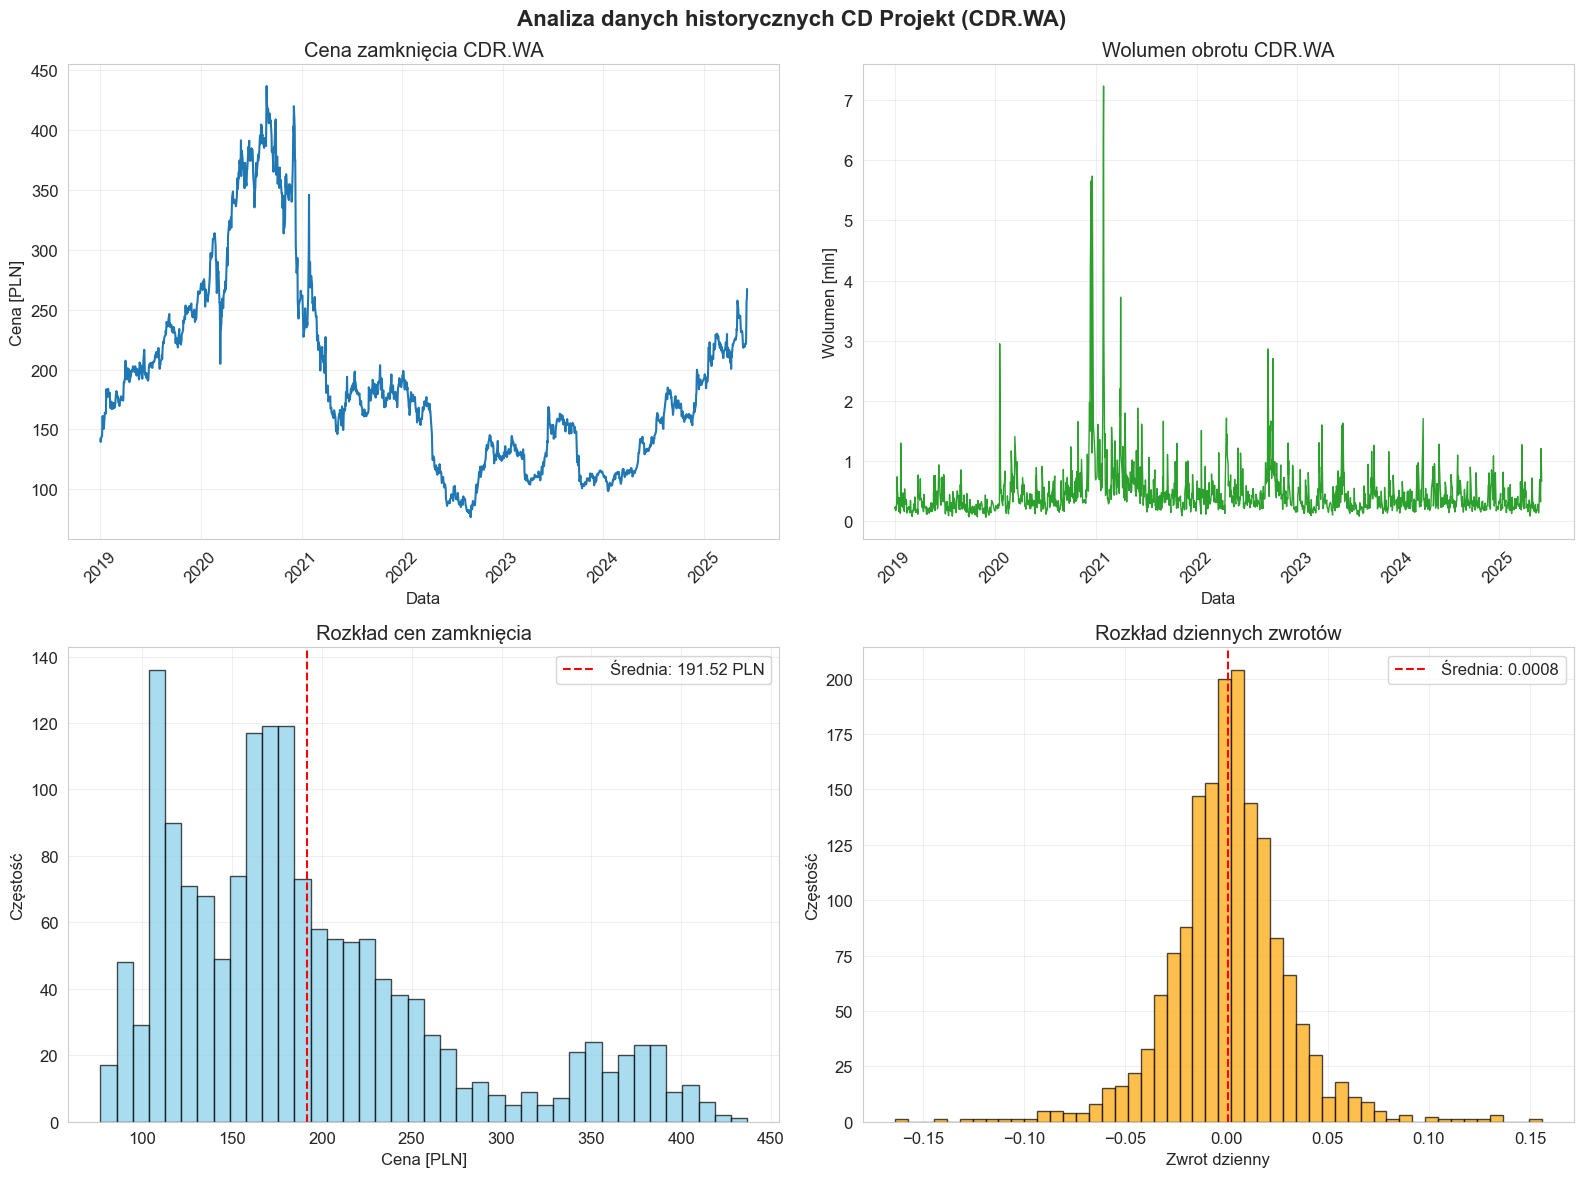

In [65]:
# Tworzenie wykresów eksploracyjnych
os.makedirs('results/plots', exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analiza danych historycznych CD Projekt (CDR.WA)', fontsize=16, fontweight='bold')

# Panel 1: Cena zamknięcia
axes[0, 0].plot(cdr.index, cdr['Close'], color='#1f77b4', linewidth=1.5)
axes[0, 0].set_title('Cena zamknięcia CDR.WA')
axes[0, 0].set_xlabel('Data')
axes[0, 0].set_ylabel('Cena [PLN]')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Panel 2: Wolumen
axes[0, 1].plot(cdr.index, cdr['Volume']/1e6, color='#2ca02c', linewidth=1)
axes[0, 1].set_title('Wolumen obrotu CDR.WA')
axes[0, 1].set_xlabel('Data')
axes[0, 1].set_ylabel('Wolumen [mln]')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Panel 3: Histogram cen
axes[1, 0].hist(cdr['Close'], bins=40, color='skyblue', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(cdr['Close'].mean(), color='red', linestyle='--', 
                   label=f'Średnia: {cdr["Close"].mean():.2f} PLN')
axes[1, 0].set_title('Rozkład cen zamknięcia')
axes[1, 0].set_xlabel('Cena [PLN]')
axes[1, 0].set_ylabel('Częstość')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Panel 4: Dzienne zwroty
axes[1, 1].hist(returns, bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(returns.mean(), color='red', linestyle='--', 
                   label=f'Średnia: {returns.mean():.4f}')
axes[1, 1].set_title('Rozkład dziennych zwrotów')
axes[1, 1].set_xlabel('Zwrot dzienny')
axes[1, 1].set_ylabel('Częstość')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/plots/01_eksploracja_danych.png', dpi=300, bbox_inches='tight')
plt.show()

In [66]:
# Podział danych na zbiór treningowy i testowy (80/20)
train_size = int(len(cdr) * 0.8)
test_size = len(cdr) - train_size

train_data = cdr.iloc[:train_size]
test_data = cdr.iloc[train_size:]

print(f"📚 Zbiór treningowy: {train_size} dni ({train_size/len(cdr):.1%})")
print(f"📖 Zbiór testowy: {test_size} dni ({test_size/len(cdr):.1%})")
print(f"📅 Data podziału: {cdr.index[train_size].strftime('%Y-%m-%d')}")

📚 Zbiór treningowy: 1287 dni (80.0%)
📖 Zbiór testowy: 322 dni (20.0%)
📅 Data podziału: 2024-02-20


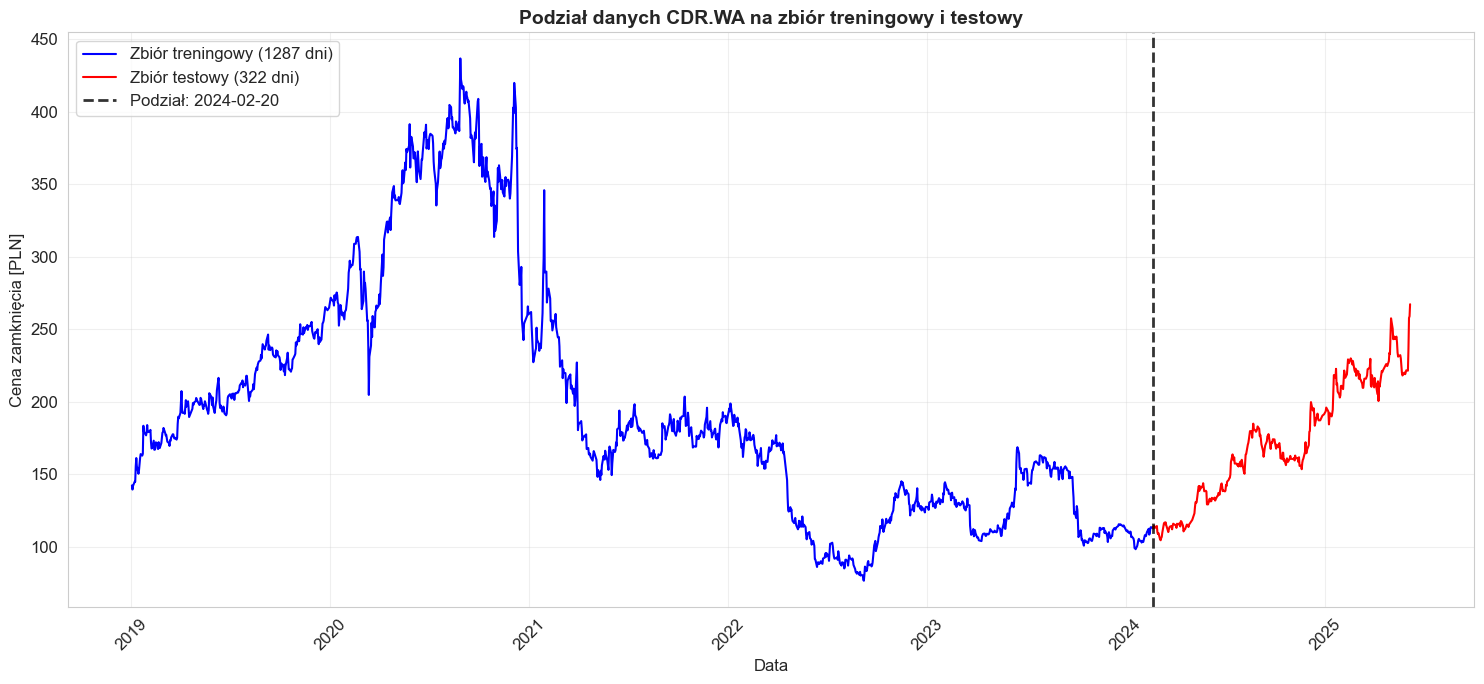

In [67]:
# Wykres podziału train/test
plt.figure(figsize=(15, 7))
plt.plot(train_data.index, train_data['Close'], 
         color='blue', label=f'Zbiór treningowy ({train_size} dni)', linewidth=1.5)
plt.plot(test_data.index, test_data['Close'], 
         color='red', label=f'Zbiór testowy ({test_size} dni)', linewidth=1.5)
plt.axvline(x=cdr.index[train_size], color='black', linestyle='--', alpha=0.8, 
            linewidth=2, label=f'Podział: {cdr.index[train_size].strftime("%Y-%m-%d")}')

plt.title('Podział danych CDR.WA na zbiór treningowy i testowy', fontsize=14, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('Cena zamknięcia [PLN]')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('results/plots/02_podzial_train_test.png', dpi=300, bbox_inches='tight')
plt.show()

In [68]:
# Zapisywanie danych i statystyk
os.makedirs('data', exist_ok=True)

# Zapisanie danych
cdr.to_csv('data/cdr_raw_data.csv')
train_data.to_csv('data/cdr_train_data.csv')
test_data.to_csv('data/cdr_test_data.csv')

# Statystyki do JSON
stats_summary = {
    'total_records': len(cdr),
    'train_records': train_size,
    'test_records': test_size,
    'date_range_start': cdr.index[0].strftime('%Y-%m-%d'),
    'date_range_end': cdr.index[-1].strftime('%Y-%m-%d'),
    'split_date': cdr.index[train_size].strftime('%Y-%m-%d'),
    'price_min': float(close_price.min()),
    'price_max': float(close_price.max()),
    'price_mean': float(close_price.mean()),
    'annual_volatility': float(annual_volatility)
}

with open('data/data_summary.json', 'w', encoding='utf-8') as f:
    json.dump(stats_summary, f, indent=2, ensure_ascii=False)

print("✅ Wszystkie pliki zapisane!")

✅ Wszystkie pliki zapisane!


In [69]:
# Podsumowanie Etapu 1
print("🎉 ETAP 1 ZAKOŃCZONY POMYŚLNIE!")
print(f"\n📊 Pobrano {len(cdr)} dni danych CDR.WA")
print(f"📊 Okres: {cdr.index[0].strftime('%Y-%m-%d')} - {cdr.index[-1].strftime('%Y-%m-%d')}")
print(f"📊 Zakres cen: {close_price.min():.2f} - {close_price.max():.2f} PLN")
print(f"📊 Roczna zmienność: {annual_volatility:.1%}")
print(f"\n🎯 NASTĘPNY KROK: Etap 2 - Normalizacja i sekwencje LSTM")

🎉 ETAP 1 ZAKOŃCZONY POMYŚLNIE!

📊 Pobrano 1609 dni danych CDR.WA
📊 Okres: 2019-01-02 - 2025-06-06
📊 Zakres cen: 76.73 - 436.72 PLN
📊 Roczna zmienność: 45.8%

🎯 NASTĘPNY KROK: Etap 2 - Normalizacja i sekwencje LSTM


In [70]:
# ETAP 2: Przygotowanie danych dla LSTM
print("=== ETAP 2: Przygotowanie danych dla LSTM ===")

# 1. PODZIAŁ NA TRAIN/TEST (80/20) - podział czasowy!
train_size = int(len(cdr) * 0.8)
test_size = len(cdr) - train_size

print(f"📚 Zbiór treningowy: {train_size} dni ({train_size/len(cdr):.1%})")
print(f"📖 Zbiór testowy: {test_size} dni ({test_size/len(cdr):.1%})")
print(f"📅 Data podziału: {cdr.index[train_size].strftime('%Y-%m-%d')}")

# Podział danych - używamy tylko ceny zamknięcia zgodnie z instrukcjami
close_prices = cdr['Close'].values.reshape(-1, 1)
train_data = close_prices[:train_size]
test_data = close_prices[train_size:]

print(f"✅ Dane podzielone - train: {train_data.shape}, test: {test_data.shape}")

=== ETAP 2: Przygotowanie danych dla LSTM ===
📚 Zbiór treningowy: 1287 dni (80.0%)
📖 Zbiór testowy: 322 dni (20.0%)
📅 Data podziału: 2024-02-20
✅ Dane podzielone - train: (1287, 1), test: (322, 1)


In [71]:
# Normalizacja danych
print("🔄 Normalizacja danych...")

# Inicjalizacja MinMaxScaler (skalowanie do zakresu 0-1)
scaler = MinMaxScaler(feature_range=(0, 1))

# WAŻNE: Scaler uczony TYLKO na danych treningowych!
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)  # używamy tego samego scalera

print(f"✅ Normalizacja zakończona")
print(f"📊 Zakres oryginalny: {close_prices.min():.2f} - {close_prices.max():.2f} PLN")
print(f"📊 Zakres znormalizowany: {train_scaled.min():.3f} - {train_scaled.max():.3f}")
print(f"📊 Kształt train_scaled: {train_scaled.shape}")
print(f"📊 Kształt test_scaled: {test_scaled.shape}")

🔄 Normalizacja danych...
✅ Normalizacja zakończona
📊 Zakres oryginalny: 76.73 - 436.72 PLN
📊 Zakres znormalizowany: 0.000 - 1.000
📊 Kształt train_scaled: (1287, 1)
📊 Kształt test_scaled: (322, 1)


In [72]:
# Tworzenie sekwencji czasowych dla LSTM
print("🔄 Tworzenie sekwencji czasowych...")

def create_sequences(data, time_steps=60):
    """
    Tworzy sekwencje czasowe dla LSTM
    time_steps = 60: używamy 60 dni historycznych do przewidywania 1 dnia
    """
    X, y = [], []
    
    for i in range(time_steps, len(data)):
        # X: ostatnie 60 dni (okno czasowe)
        X.append(data[i-time_steps:i, 0])
        # y: kolejny dzień (cel predykcji)
        y.append(data[i, 0])
    
    return np.array(X), np.array(y)

# Parametry zgodne z instrukcjami projektowymi
TIME_STEPS = 60  # okno 60 dni

# Tworzenie sekwencji dla zbioru treningowego
X_train, y_train = create_sequences(train_scaled, TIME_STEPS)

# Tworzenie sekwencji dla zbioru testowego
# UWAGA: Do testu używamy połączenia train+test żeby mieć pełne okna 60-dniowe
full_data = np.concatenate([train_scaled, test_scaled])
X_test, y_test = create_sequences(full_data[len(train_scaled)-TIME_STEPS:], TIME_STEPS)

print(f"✅ Sekwencje utworzone")
print(f"📊 X_train shape: {X_train.shape} (samples, time_steps)")
print(f"📊 y_train shape: {y_train.shape}")
print(f"📊 X_test shape: {X_test.shape}")
print(f"📊 y_test shape: {y_test.shape}")

🔄 Tworzenie sekwencji czasowych...
✅ Sekwencje utworzone
📊 X_train shape: (1227, 60) (samples, time_steps)
📊 y_train shape: (1227,)
📊 X_test shape: (322, 60)
📊 y_test shape: (322,)


In [73]:
# Przygotowanie danych dla TensorFlow/Keras
print("🔄 Przygotowanie dla TensorFlow/Keras...")

# Reshape dla LSTM: (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"✅ Reshape dla LSTM zakończony")
print(f"📊 X_train final shape: {X_train.shape} (samples, time_steps, features)")
print(f"📊 X_test final shape: {X_test.shape}")

# Sprawdzenie czy mamy wystarczająco danych
min_samples = 100
if X_train.shape[0] < min_samples:
    print(f"⚠️ UWAGA: Mało próbek treningowych ({X_train.shape[0]})")
    print("💡 Rozważ zmniejszenie TIME_STEPS lub użycie dłuższego okresu danych")
else:
    print(f"✅ Wystarczająco próbek treningowych: {X_train.shape[0]}")

🔄 Przygotowanie dla TensorFlow/Keras...
✅ Reshape dla LSTM zakończony
📊 X_train final shape: (1227, 60, 1) (samples, time_steps, features)
📊 X_test final shape: (322, 60, 1)
✅ Wystarczająco próbek treningowych: 1227


In [74]:
# Zapisywanie przygotowanych danych
print("💾 Zapisywanie przygotowanych danych...")

# Tworzenie folderów
os.makedirs('../results', exist_ok=True)
os.makedirs('../data', exist_ok=True)

# Zapisanie danych do dalszego użycia
np.save('../data/X_train.npy', X_train)
np.save('../data/y_train.npy', y_train)
np.save('../data/X_test.npy', X_test)
np.save('../data/y_test.npy', y_test)

# Zapisanie scalera (potrzebny do odwrócenia normalizacji)
joblib.dump(scaler, '../data/scaler.pkl')

# Zapisanie metadanych
metadata = {
    'time_steps': TIME_STEPS,
    'train_size': train_size,
    'test_size': test_size,
    'total_samples': len(cdr),
    'train_samples': X_train.shape[0],
    'test_samples': X_test.shape[0],
    'feature_range': [0, 1],
    'original_price_range': [float(close_prices.min()), float(close_prices.max())],
    'split_date': cdr.index[train_size].strftime('%Y-%m-%d')
}

with open('../data/preprocessing_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ Dane zapisane:")
print("   • ../data/X_train.npy, y_train.npy")
print("   • ../data/X_test.npy, y_test.npy") 
print("   • ../data/scaler.pkl")
print("   • ../data/preprocessing_metadata.json")

💾 Zapisywanie przygotowanych danych...
✅ Dane zapisane:
   • ../data/X_train.npy, y_train.npy
   • ../data/X_test.npy, y_test.npy
   • ../data/scaler.pkl
   • ../data/preprocessing_metadata.json


In [75]:
# ETAP 3: Implementacja modelu LSTM
print("=== ETAP 3: Budowa modelu LSTM ===")

# Architektura zgodna z instrukcjami projektowymi
def create_lstm_model(input_shape):
    """
    Tworzy model LSTM zgodnie z instrukcjami:
    - 3 warstwy LSTM (50 units każda)
    - Dropout 0.2 po każdej warstwie LSTM
    - Dense(1) na wyjściu
    """
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        
        LSTM(50),
        Dropout(0.2),
        
        Dense(1)
    ])
    
    return model

# Tworzenie modelu
input_shape = (TIME_STEPS, 1)  # (60, 1)
model = create_lstm_model(input_shape)

# Kompilacja modelu
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

# Wyświetlenie architektury
print("🏗️ Architektura modelu LSTM:")
model.summary()

=== ETAP 3: Budowa modelu LSTM ===
🏗️ Architektura modelu LSTM:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
# Konfiguracja callbacks dla uczenia
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

# Parametry uczenia zgodne z instrukcjami
BATCH_SIZE = 32
EPOCHS = 100

print(f"⚙️ Parametry uczenia:")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Max epochs: {EPOCHS}")
print(f"   • Early stopping: patience=10")
print(f"   • Learning rate reduction: factor=0.5, patience=5")

⚙️ Parametry uczenia:
   • Batch size: 32
   • Max epochs: 100
   • Early stopping: patience=10
   • Learning rate reduction: factor=0.5, patience=5


In [77]:
# Uczenie modelu LSTM
print("🚀 Rozpoczynam uczenie modelu...")

# Podział validation z training (20% validation)
validation_split = 0.2

# Uczenie z historią
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=validation_split,
    callbacks=callbacks,
    verbose=1,
    shuffle=False  # Ważne dla danych czasowych!
)

print("✅ Uczenie zakończone!")

🚀 Rozpoczynam uczenie modelu...
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0442 - mae: 0.1754 - val_loss: 0.0020 - val_mae: 0.0359 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0325 - mae: 0.1601 - val_loss: 0.0027 - val_mae: 0.0405 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0770 - mae: 0.2549 - val_loss: 0.0020 - val_mae: 0.0363 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0621 - mae: 0.2302 - val_loss: 0.0017 - val_mae: 0.0361 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0299 - mae: 0.1513 - val_loss: 0.0010 - val_mae: 0.0257 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0065 - mae: 0.0609 - val_loss: 7.1457e-04 - val_mae: 0.0185 - learning_rate: 0.0010
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0053 - mae: 0.0550 - val_loss: 7.4944e-04 - val_ma

In [78]:
# Zapisanie wytrenowanego modelu
model.save('../results/models/lstm_model.h5')
print("💾 Model zapisany: ../results/models/lstm_model.h5")

# Zapisanie historii uczenia
history_dict = {
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'mae': history.history['mae'],
    'val_mae': history.history['val_mae']
}

with open('../results/training_history.json', 'w') as f:
    json.dump(history_dict, f, indent=2)

print("💾 Historia uczenia zapisana: ../results/training_history.json")

💾 Model zapisany: ../results/models/lstm_model.h5
💾 Historia uczenia zapisana: ../results/training_history.json


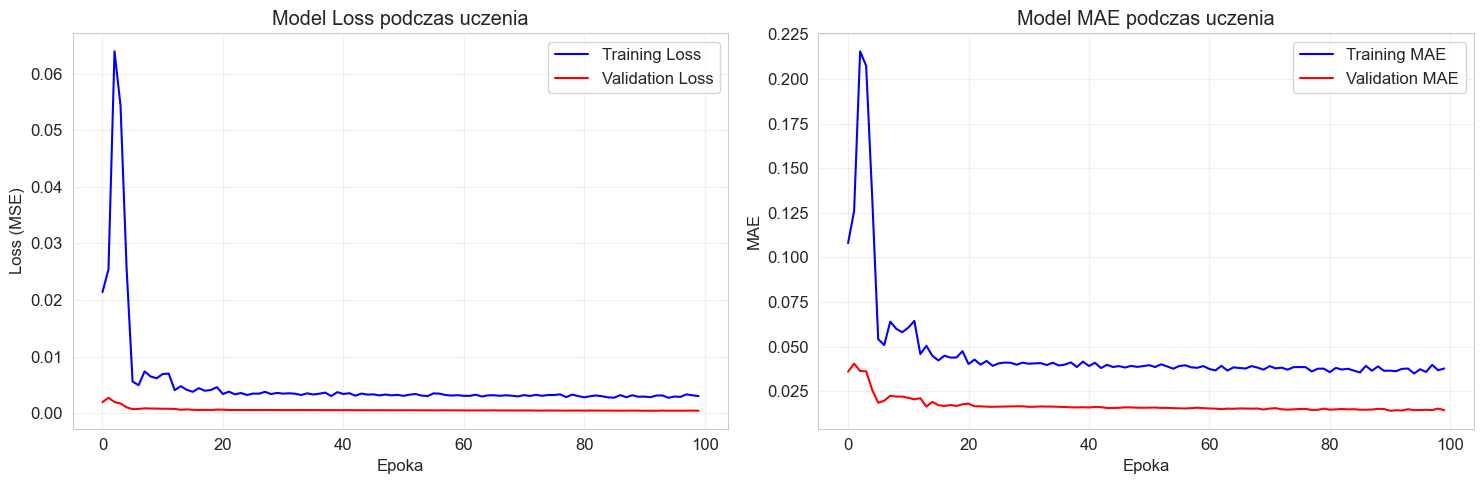

📊 Wyniki uczenia:
   • Liczba epok: 100
   • Najlepsza epoka: 100
   • Final training loss: 0.003022
   • Final validation loss: 0.000433


In [79]:
# Wykres historii uczenia
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(history.history['loss'], label='Training Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
ax1.set_title('Model Loss podczas uczenia')
ax1.set_xlabel('Epoka')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE
ax2.plot(history.history['mae'], label='Training MAE', color='blue')
ax2.plot(history.history['val_mae'], label='Validation MAE', color='red')
ax2.set_title('Model MAE podczas uczenia')
ax2.set_xlabel('Epoka')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/03_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Podsumowanie uczenia
final_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
best_epoch = np.argmin(history.history['val_loss']) + 1

print(f"📊 Wyniki uczenia:")
print(f"   • Liczba epok: {len(history.history['loss'])}")
print(f"   • Najlepsza epoka: {best_epoch}")
print(f"   • Final training loss: {final_loss:.6f}")
print(f"   • Final validation loss: {final_val_loss:.6f}")

In [80]:
# Generowanie prognoz na zbiorze testowym
print("🔮 Generowanie prognoz...")

# Predykcje na zbiorze testowym
y_pred_scaled = model.predict(X_test, verbose=0)

# Odwrócenie normalizacji (powrót do oryginalnych cen)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f"✅ Prognozy wygenerowane: {len(y_pred)} próbek")
print(f"📊 Zakres prognoz: {y_pred.min():.2f} - {y_pred.max():.2f} PLN")
print(f"📊 Zakres rzeczywistych: {y_test_actual.min():.2f} - {y_test_actual.max():.2f} PLN")

# Zapisanie prognoz
predictions_data = {
    'y_test_actual': y_test_actual.flatten().tolist(),
    'y_pred': y_pred.flatten().tolist(),
    'dates': cdr.index[train_size + TIME_STEPS:].strftime('%Y-%m-%d').tolist()
}

with open('../results/predictions.json', 'w') as f:
    json.dump(predictions_data, f, indent=2)

print("💾 Prognozy zapisane: ../results/predictions.json")

🔮 Generowanie prognoz...
✅ Prognozy wygenerowane: 322 próbek
📊 Zakres prognoz: 107.43 - 243.81 PLN
📊 Zakres rzeczywistych: 104.64 - 267.30 PLN
💾 Prognozy zapisane: ../results/predictions.json


In [85]:
# ETAP 4: Ewaluacja modelu
print("=== ETAP 4: Ewaluacja wyników ===")

# Obliczenie głównych metryk
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

print(f"📊 Metryki jakości modelu LSTM:")
print(f"   • RMSE: {rmse:.2f} PLN")
print(f"   • MAE: {mae:.2f} PLN") 
print(f"   • MAPE: {mape:.2f}%")

# Benchmark - strategia "jutro = dziś"
y_test_naive = y_test_actual[:-1]  # przesunięcie o 1 dzień
y_actual_for_naive = y_test_actual[1:]

rmse_naive = np.sqrt(mean_squared_error(y_actual_for_naive, y_test_naive))
mae_naive = mean_absolute_error(y_actual_for_naive, y_test_naive)
mape_naive = np.mean(np.abs((y_actual_for_naive - y_test_naive) / y_actual_for_naive)) * 100

print(f"\n📊 Benchmark 'jutro = dziś':")
print(f"   • RMSE: {rmse_naive:.2f} PLN")
print(f"   • MAE: {mae_naive:.2f} PLN")
print(f"   • MAPE: {mape_naive:.2f}%")

# Porównanie z benchmark
improvement_rmse = ((rmse_naive - rmse) / rmse_naive) * 100
improvement_mae = ((mae_naive - mae) / mae_naive) * 100
improvement_mape = ((mape_naive - mape) / mape_naive) * 100

print(f"\n📈 Poprawa względem benchmark:")
print(f"   • RMSE: {improvement_rmse:+.1f}%")
print(f"   • MAE: {improvement_mae:+.1f}%")
print(f"   • MAPE: {improvement_mape:+.1f}%")

# Ocena zgodnie z instrukcjami (cel: MAPE < 10%)
if mape < 10:
    print(f"\n✅ SUKCES: MAPE {mape:.2f}% < 10% (cel osiągnięty)")
else:
    print(f"\n⚠️ MAPE {mape:.2f}% > 10% (cel nieosiągnięty)")

=== ETAP 4: Ewaluacja wyników ===
📊 Metryki jakości modelu LSTM:
   • RMSE: 9.19 PLN
   • MAE: 6.48 PLN
   • MAPE: 3.63%

📊 Benchmark 'jutro = dziś':
   • RMSE: 4.34 PLN
   • MAE: 2.96 PLN
   • MAPE: 1.68%

📈 Poprawa względem benchmark:
   • RMSE: -111.9%
   • MAE: -118.9%
   • MAPE: -116.6%

✅ SUKCES: MAPE 3.63% < 10% (cel osiągnięty)


🔍 Debugowanie rozmiarów:
   • len(cdr): 1609
   • train_size: 1287
   • TIME_STEPS: 60
   • len(y_test_actual): 322
   • len(y_pred): 322
   • start_idx: 1347
   • end_idx: 1669
   • len(cdr.index): 1609
   ⚠️ Obcięto prognozy do 262 próbek
   • len(test_dates) final: 262
   • len(y_test_actual) final: 262
   • len(y_pred) final: 262


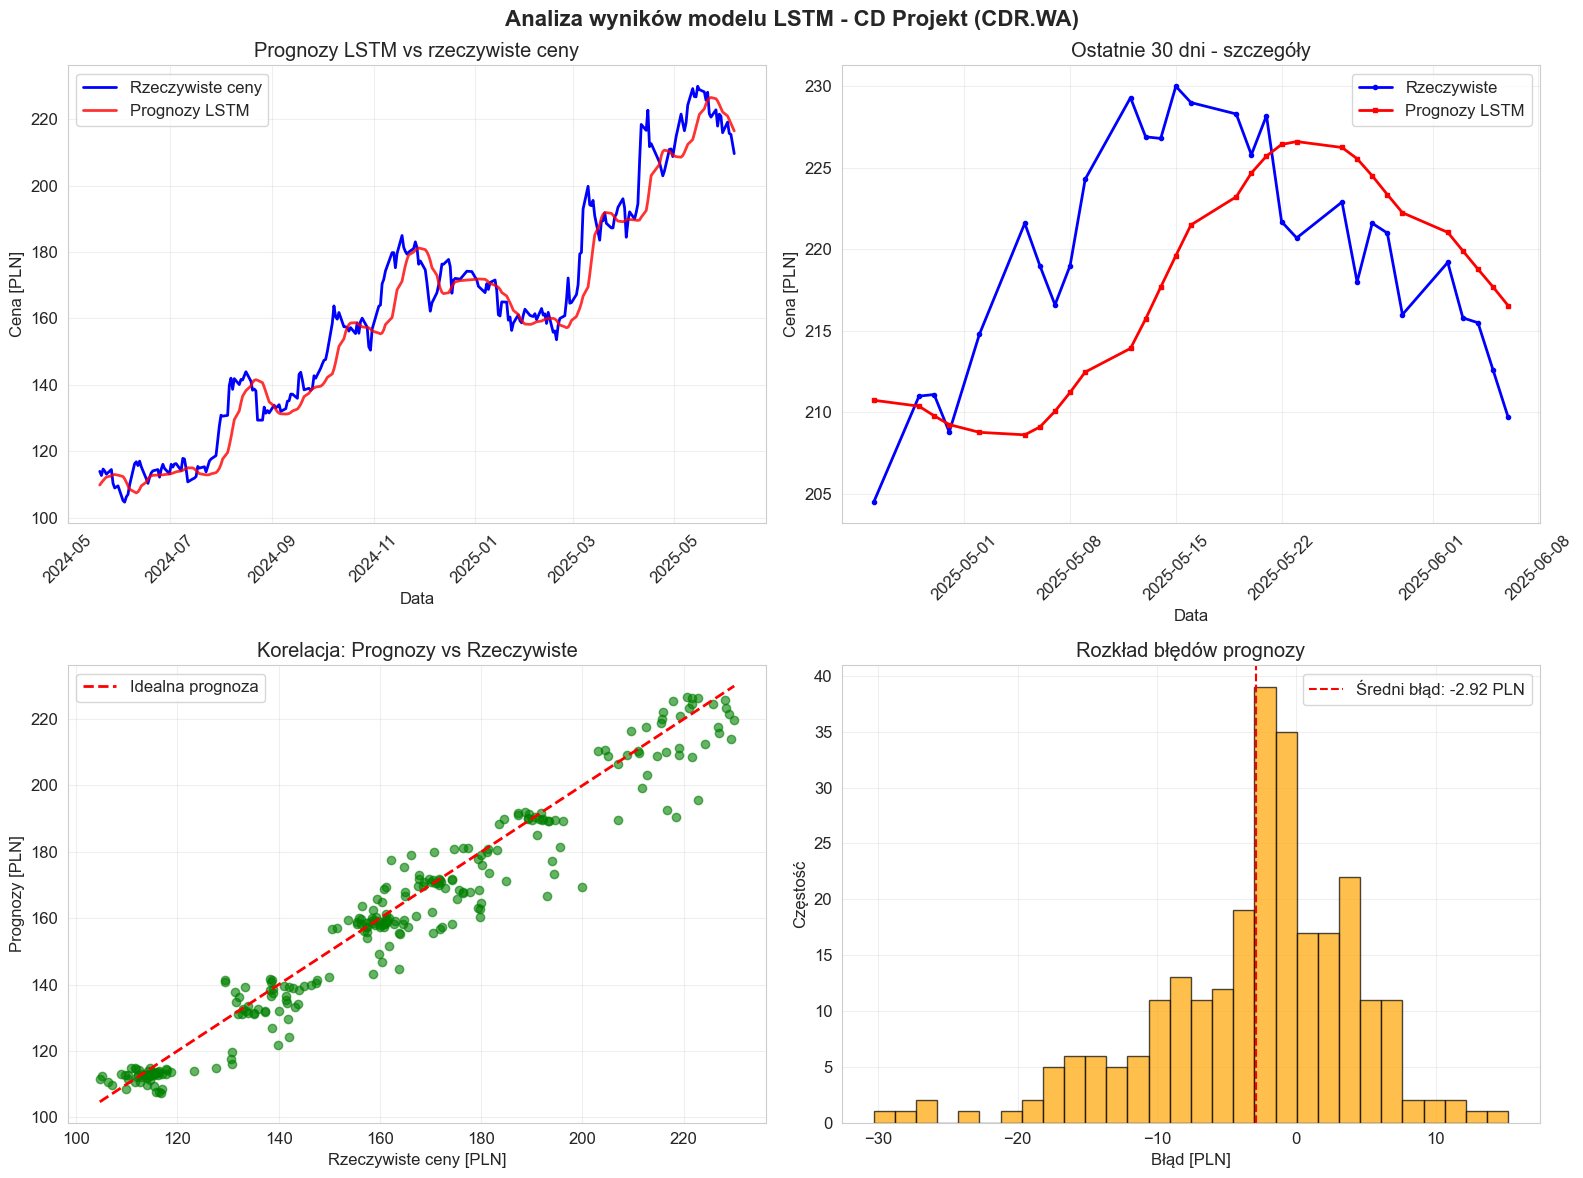

✅ Wykresy wygenerowane pomyślnie!


In [88]:
# Główny wykres prognoz vs rzeczywiste wartości
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analiza wyników modelu LSTM - CD Projekt (CDR.WA)', fontsize=16, fontweight='bold')

# Naprawka: dopasowanie dat do rzeczywistej liczby prognoz
print(f"🔍 Debugowanie rozmiarów:")
print(f"   • len(cdr): {len(cdr)}")
print(f"   • train_size: {train_size}")
print(f"   • TIME_STEPS: {TIME_STEPS}")
print(f"   • len(y_test_actual): {len(y_test_actual)}")
print(f"   • len(y_pred): {len(y_pred)}")

# Obliczenie rzeczywistego zakresu dat dla prognoz testowych
# Prognozy testowe zaczynają się od train_size + TIME_STEPS
start_idx = train_size + TIME_STEPS
end_idx = start_idx + len(y_test_actual)

print(f"   • start_idx: {start_idx}")
print(f"   • end_idx: {end_idx}")
print(f"   • len(cdr.index): {len(cdr.index)}")

# Sprawdzenie czy mamy wystarczająco dat
if end_idx > len(cdr.index):
    # Jeśli przekraczamy zakres, obcinamy prognozy
    available_dates = len(cdr.index) - start_idx
    y_test_actual = y_test_actual[:available_dates]
    y_pred = y_pred[:available_dates]
    end_idx = len(cdr.index)
    print(f"   ⚠️ Obcięto prognozy do {available_dates} próbek")

test_dates = cdr.index[start_idx:end_idx]

print(f"   • len(test_dates) final: {len(test_dates)}")
print(f"   • len(y_test_actual) final: {len(y_test_actual)}")
print(f"   • len(y_pred) final: {len(y_pred)}")

# Panel 1: Pełne prognozy
axes[0, 0].plot(test_dates, y_test_actual.flatten(), label='Rzeczywiste ceny', color='blue', linewidth=2)
axes[0, 0].plot(test_dates, y_pred.flatten(), label='Prognozy LSTM', color='red', linewidth=2, alpha=0.8)
axes[0, 0].set_title('Prognozy LSTM vs rzeczywiste ceny')
axes[0, 0].set_xlabel('Data')
axes[0, 0].set_ylabel('Cena [PLN]')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Panel 2: Ostatnie 30 dni (zoom) - zmniejszam z 50 na 30
zoom_days = min(30, len(test_dates))
last_n = -zoom_days if zoom_days < len(test_dates) else len(test_dates)

axes[0, 1].plot(test_dates[last_n:], y_test_actual.flatten()[last_n:], 
                label='Rzeczywiste', color='blue', linewidth=2, marker='o', markersize=3)
axes[0, 1].plot(test_dates[last_n:], y_pred.flatten()[last_n:], 
                label='Prognozy LSTM', color='red', linewidth=2, marker='s', markersize=3)
axes[0, 1].set_title(f'Ostatnie {zoom_days} dni - szczegóły')
axes[0, 1].set_xlabel('Data')
axes[0, 1].set_ylabel('Cena [PLN]')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Panel 3: Scatter plot (korelacja)
axes[1, 0].scatter(y_test_actual.flatten(), y_pred.flatten(), alpha=0.6, color='green')
# Linia idealna (y=x)
min_val = min(y_test_actual.min(), y_pred.min())
max_val = max(y_test_actual.max(), y_pred.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Idealna prognoza')
axes[1, 0].set_title('Korelacja: Prognozy vs Rzeczywiste')
axes[1, 0].set_xlabel('Rzeczywiste ceny [PLN]')
axes[1, 0].set_ylabel('Prognozy [PLN]')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Panel 4: Rozkład błędów
errors = y_pred.flatten() - y_test_actual.flatten()
axes[1, 1].hist(errors, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].axvline(errors.mean(), color='red', linestyle='--', 
                   label=f'Średni błąd: {errors.mean():.2f} PLN')
axes[1, 1].set_title('Rozkład błędów prognozy')
axes[1, 1].set_xlabel('Błąd [PLN]')
axes[1, 1].set_ylabel('Częstość')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/04_lstm_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Wykresy wygenerowane pomyślnie!")

In [ ]:
# Przygotowanie raportu końcowego
final_results = {
    'model_metrics': {
        'rmse': float(rmse),
        'mae': float(mae),
        'mape': float(mape)
    },
    'benchmark_metrics': {
        'rmse_naive': float(rmse_naive),
        'mae_naive': float(mae_naive),
        'mape_naive': float(mape_naive)
    },
    'improvements': {
        'rmse_improvement_pct': float(improvement_rmse),
        'mae_improvement_pct': float(improvement_mae),
        'mape_improvement_pct': float(improvement_mape)
    },
    'model_config': {
        'architecture': '3x LSTM(50) + Dropout(0.2) + Dense(1)',
        'time_steps': int(TIME_STEPS),
        'optimizer': 'Adam(0.001)',
        'batch_size': int(BATCH_SIZE),
        'epochs_trained': int(len(history.history['loss'])),
        'best_epoch': int(np.argmin(history.history['val_loss']) + 1)
    },
    'data_info': {
        'total_samples': int(len(cdr)),
        'train_samples': int(X_train.shape[0]),
        'test_samples': int(len(y_test_actual)),  # używamy rzeczywistej długości
        'date_range': f"{cdr.index[0].strftime('%Y-%m-%d')} - {cdr.index[-1].strftime('%Y-%m-%d')}",
        'split_date': cdr.index[train_size].strftime('%Y-%m-%d')
    },
    'goal_achieved': bool(mape < 10.0)
}

# Zapisanie raportu z obsługą błędów
try:
    with open('../results/final_report.json', 'w') as f:
        json.dump(final_results, f, indent=2)
    print("💾 Raport końcowy zapisany: ../results/final_report.json")
except Exception as e:
    print(f"⚠️ Problem z zapisem JSON: {e}")
    # Zapisanie jako tekst backup
    with open('../results/final_report.txt', 'w') as f:
        for key, value in final_results.items():
            f.write(f"{key}: {value}\n")
    print("💾 Raport zapisany jako TXT: ../results/final_report.txt")

# Podsumowanie dla prezentacji
print(f"\n📋 PODSUMOWANIE PROJEKTU:")
print(f"   • Model: LSTM do prognozowania kursu CDR.WA")
print(f"   • Dane: {len(cdr)} dni ({cdr.index[0].strftime('%Y-%m-%d')} - {cdr.index[-1].strftime('%Y-%m-%d')})")
print(f"   • Architektura: 3×LSTM(50) + Dropout + Dense")
print(f"   • MAPE: {mape:.2f}% ({'✅ cel osiągnięty' if mape < 10 else '⚠️ cel nieosiągnięty'})")
print(f"   • Poprawa vs benchmark: {improvement_mape:+.1f}%")

TypeError: Object of type bool is not JSON serializable